In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#import control
import scipy.linalg as linalg
%matplotlib notebook

13.02


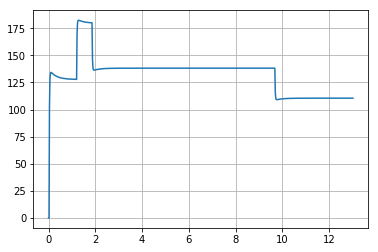

In [3]:
rocket_angle = pd.read_csv("Data.csv")
print(rocket_angle.get_values()[:,0][-1])
data = rocket_angle.get_values()
[fig, ax] = plt.subplots()
ax.plot(data[:,0], data[:,1])
plt.grid(True)

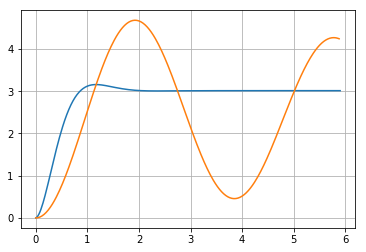

In [5]:
I = 0.375
b = 0.1*0.4

sys = control.tf([1/I], [1, b/I, 0])

sys_fb = control.feedback(sys, 1)

dt = rocket_angle.get_values()[:,0][1]
T = rocket_angle.get_values()[:,0][-1]
n = T/dt

t = dt*np.arange(0, n)
u = np.deg2rad(141)*np.ones_like(t)

y = control.forced_response(sys_fb, t, u)[1]

[fig, ax] = plt.subplots()
ax.plot(data[:,0], np.deg2rad(data[:,1]))
ax.plot(t, y)
plt.grid(True)


In [6]:
[10*np.sin(1), -10*np.cos(1)]

[8.414709848078965, -5.403023058681398]

In [9]:
I = 0.375
b = 1
b = b*0.4
print(b / 0.1)

kp = 7
ki = 0
kd = 2

sys = control.tf([1/I], [1, b/I, 0])

sys_fb = control.feedback(sys, 1)

dt = rocket_angle.get_values()[:,0][1]
T = 10
n = T/dt

t = dt*np.arange(0, n)
u = np.deg2rad(175)*np.ones_like(t)

y = control.forced_response(sys_fb, t, u)[1]

pid = control.tf([kd, kp, ki], [1, 0])
print(pid)

y_pid = control.forced_response(control.feedback(pid*sys, 1), t, u)[1]

[fig, ax] = plt.subplots()
ax.plot(t, np.rad2deg(y))
ax.plot(t, np.rad2deg(y_pid))
ax.plot(t, np.rad2deg(u), linestyle = ':')
ax.plot(data[:,0], data[:,1], linestyle = '--')

plt.grid(True)
ax.set_xlim([0, T])

4.0

2 s^2 + 7 s
-----------
     s



(0, 10)

In [17]:
# %load controllers.py
"""
Created on Wed Feb 13 17:36:20 2019

@author: Dan-Laptop
"""

import numpy as np

class PIR:
    def __init__(self, kp = 0, ki = 0, kd = 0, u_min = -np.inf, u_max = np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.last_y = 0
        self.last_t = 0
        self.init = False
        
        if(u_min == -np.inf) & (u_max == np.inf):
            self.clamp_out = False
        else:
            self.clamp_out = True
            self.u_min = u_min
            self.u_max = u_max
        
    def eval(self, y_c, y, y_dot, dt):
        error = y_c - y

        self.integral += dt*error
        out = (self.kp*error 
            + self.ki*self.integral
            - self.kd*y_dot)

        if(self.clamp_out):
            out = self.clamp(out, error, dt)
            
        return out
    
    def eval_alt(self, y_c, y, time):
        error = y_c - y
        dt = time - self.last_t
        
        if(self.init):
            self.integral += dt*error
            y_dot = (y - self.last_y) / dt
        else:
            y_dot = 0
        
        out = (self.kp*error
               + self.ki*self.integral
               - self.kd*y_dot)
        
        self.last_y = y
        self.last_t = time
        self.init = True
        
        if(self.clamp_out):
            out = self.clamp(out, error, dt)
            
        return out
        
        
        
    def clamp(self, out, error, dt):
        if(out > self.u_max):
            out = self.u_max
            
            if(self.ki*error > 0):
                self.integral -= dt*error
                
        elif(out < self.u_min):
            out = self.u_min
            
            if(self.ki*error < 0):
                self.integral -= dt*error
            
        return out
    
class PID:
    def __init__(self, kp = 0, ki = 0, kd = 0, u_min = -np.inf, u_max = np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.integral = 0
        self.last_error = 0
        self.last_t = 0
        self.init = False
        
        if(u_min == -np.inf) & (u_max == np.inf):
            self.clamp_out = False
        else:
            self.clamp_out = True
            self.u_min = u_min
            self.u_max = u_max
        
    def eval(self, y_c, y, dt):
        error = y_c - y
        
        if(self.init):
            derror = (error - self.last_error) / dt
        else:
            derror = 0
        
        self.integral += dt*error
        out = (self.kp*error 
            + self.ki*self.integral
            - self.kd*derror)
        
        self.last_error = error
        self.init = True
        
        if(self.clamp_out):
            out = self.clamp(out, error, dt)
            
        return out
    
        
    def clamp(self, out, error, dt):
        if(out > self.u_max):
            out = self.u_max
            
            if(self.ki*error > 0):
                self.integral -= dt*error
                
        elif(out < self.u_min):
            out = self.u_min
            
            if(self.ki*error < 0):
                self.integral -= dt*error
            
        return out

In [31]:
A = np.matrix([[0, 1],[0, -b/I]])
B = np.matrix([[0],[1/I]])
C = np.matrix([1, 0])
D = 0

dt = 0.02

G = linalg.expm(A*dt)
H = linalg.inv(A)
print(H)

LinAlgError: singular matrix